In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import matplotlib.pyplot as plt
import pickle
import mygene
from os import path
import scipy.sparse
import scipy.io
import json

In [2]:
def make_raw_dataset(samples, path, name):
    """
    Function to load, preprocess and concatenate a dataset from multiple RNAseq
     samples
    Inputs:
     samples, dictionary of sample file prefixes as keys and timepoint metadata
      as values
     path, path to directory containing sample files
     name, dataset name for labeling AnnData object metadata
    Output: AnnData object of concatenated samples, annotated with dataset,
     timepoint, and sample id labels
    """
    anndata_dict = {}

    for sm in samples.keys():
        print(sm)

        # read in data from GEO file
        data = sc.read_10x_mtx(path, prefix=sm, cache=True)

        # add metadata information
        data.obs['dataset'] = name
        data.obs['timepoint'] = samples[sm]

        # add to dict for concatenation
        anndata_dict[sm] = data

    # concatenate samples
    data_full = ad.concat(anndata_dict, join='outer', label='sample id', index_unique='_', fill_value=0.0)
    return data_full


def make_all_raw_datasets(samples, paths, names, meta, keep_n_geens=10000, normalize=True, filter_genes=True):
    """
    reads all datasets and performs integration
    :param samples: list of samples
    :param paths: list of paths
    :param names: list of names
    :param meta: list of metadata locations
    :return:
    """
    datasets = []
    for i in range(len(meta)):
        # make raw datsets using helper functions
        if meta[i] is None:
            dataset = make_raw_dataset(samples[i], paths[i], names[i])
            if filter_genes:
                sc.pp.filter_genes(dataset, min_cells=10)
            if normalize:
                run_normalization(dataset, n_top_genes=keep_n_geens, plot=True)
            datasets.append(dataset)
     
    # concatenate data
    all_data = ad.concat(datasets, join='outer', label='sample id', index_unique='_', fill_value=0.0)

    # run harmony
    run_harmony_integration(all_data, normalize=False)

    # save data to reduce computation time
    with open('all_integrated', 'wb') as f:
        pickle.dump(all_data, f)

    datasets_integrated = []
    for name in names:
        dataset_int = all_data[np.equal(all_data.obs['dataset'], name), :]
        name_str =  name + '_integrated'
        with open(name_str, 'wb') as f:
            pickle.dump(dataset_int, f)
        datasets_integrated.append(dataset_int)
    return all_data, datasets_integrated


def run_normalization(dataset, n_top_genes=None, plot=False):
    """
    Runs normalization and filtering based on zheng17 paper
    :param dataset: AnnData dataset
    :return: filtered dataset
    """
    print("dataset_shape before norm:", dataset.shape)
    norm_data = sc.pp.recipe_zheng17(dataset, n_top_genes=n_top_genes, log=True, plot=plot)
    return norm_data


def run_harmony_integration(dataset, normalize=True):
    """
    Runs harmony integration and return dataframe
    :param dataset: anndata dataset to analyze
    :return: pandas dataframe with principal components and
    modified principal components
    """
    if normalize:
        run_normalization(dataset)
    sc.tl.pca(dataset)
    sce.pp.harmony_integrate(dataset, 'dataset')
    result_df = dataset.obsm.to_df()
    result_df['Sample ID'] = dataset.obs['sample id']
    ids = list(set(dataset.obs['sample id']))
    id_map = [(ids[i], i) for i in range(len(ids))]
    id_map = dict(id_map)
    result_df['color'] = [id_map[idx] for idx in dataset.obs['sample id']]
    return result_df

In [56]:
samples_by_day = {
    'GSM2836267_D0.': 'D0',
#     'GSM2836268_D2-1.': 'D2',
#     'GSM2836269_D2-2.': 'D2',
#     'GSM2836270_D4-1.': 'D4',
#     'GSM2836271_D4-2.': 'D4',
#     'GSM2836272_D6-1.': 'D6',
#     'GSM2836273_D6-2.': 'D6',
#     'GSM2836274_D8-1.': 'D8',
#     'GSM2836275_D8-2.': 'D8',
#     'GSM2836276_D9-1-2i.': 'D9',
#     'GSM2836277_D9-2-2i.': 'D9',
#     'GSM2836278_D10-1-2i.': 'D10',
#     'GSM2836279_D10-2-2i.': 'D10',
#     'GSM2836280_D11-2i.': 'D11',
#     'GSM2836281_D12-1-2i.': 'D12',
#     'GSM2836282_D12-2-2i.': 'D12',
#     'GSM2836283_D16-2i.': 'D16',
   'GSM2836284_iPSCs-2i.': 'iPSCs',
#     'GSM2836288_iPSCs-serum.': 'iPSCs',
}

SAMPLES = [samples_by_day]
PATHS = ['./raw']
NAMES = ['shiebinger']
META = [None]

all_data, all_sets = make_all_raw_datasets(SAMPLES, PATHS, NAMES, META, keep_n_geens=14_000, normalize=False, filter_genes=False)

GSM2836267_D0.
GSM2836284_iPSCs-2i.


2022-06-13 20:00:22,679 - harmonypy - INFO - Iteration 1 of 10
2022-06-13 20:00:23,872 - harmonypy - INFO - Iteration 2 of 10
2022-06-13 20:00:25,119 - harmonypy - INFO - Iteration 3 of 10
2022-06-13 20:00:26,304 - harmonypy - INFO - Iteration 4 of 10
2022-06-13 20:00:26,750 - harmonypy - INFO - Converged after 4 iterations
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/ipykernel_launcher.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/ipykernel_launcher.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [57]:
all_data_df = all_data.to_df()
all_data_df.head()

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACACTTTC-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACCTTGGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGCTGTGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACATTGGTTCGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACATTGTCCTTA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
select_cols = ['Sox2',
 'Obox6',
 'Klf4',
 'Esrrb',
 'Hmx1',
 'Myc',
 'Pou5f1',
 'Elf2',
 'Fmnl2',
 'Nfkb1',
 'Sirt7',
 'Rfx3',
 'Nr1i3',
 'Rfx5',
 'Hmg20a',
 'Ppp1r13b',
 'Polr3e',
 'Gmeb2',
 'Gmeb1',
 'Zfp282',
 'Ep300',
 'B930041F14Rik',
 'Zfp2',
 'Hdac10',
 'Asb6',
 'Zfp37',
 'Pou2f3',
 'Gdf9']

In [59]:
all_data_df = all_data_df[select_cols]

In [60]:
all_data_df.head()

,Sox2,Obox6,Klf4,Esrrb,Hmx1,Myc,Pou5f1,Elf2,Fmnl2,Nfkb1,...,Gmeb1,Zfp282,Ep300,B930041F14Rik,Zfp2,Hdac10,Asb6,Zfp37,Pou2f3,Gdf9
AAACATACACTTTC-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATACCTTGGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AAACATTGCTGTGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTCGA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTCCTTA-1_GSM2836267_D0._0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
master_regulators = ['Sox2', 'Klf4', 'Esrrb', 'Myc', 'Pou5f1', 'Elf2', 'Rfx3', 'Hmg20a', 'Ppp1r13b', 'Gmeb2', 'Gmeb1', 'Zfp282', 'B930041F14Rik', 'Hdac10', 'Zfp37']

In [41]:
labels = np.array([1 if 'iPSCs' in sample else 0 for sample in all_data_df.index])
print(labels)
genes_names = all_data_df.columns
print(genes_names)
all_data_df['labels'] = labels
all_data_df.head()
np.save("graph-experiments/28_genes_last_col_are_labels.npy", all_data_df)

[0 0 0 ... 1 1 1]
Index(['Sox2', 'Obox6', 'Klf4', 'Esrrb', 'Hmx1', 'Myc', 'Pou5f1', 'Elf2',
       'Fmnl2', 'Nfkb1', 'Sirt7', 'Rfx3', 'Nr1i3', 'Rfx5', 'Hmg20a',
       'Ppp1r13b', 'Polr3e', 'Gmeb2', 'Gmeb1', 'Zfp282', 'Ep300',
       'B930041F14Rik', 'Zfp2', 'Hdac10', 'Asb6', 'Zfp37', 'Pou2f3', 'Gdf9'],
      dtype='object')


In [66]:
str_to_int = {'Sox2': 0,
 'Obox6': 1,
 'Klf4': 2,
 'Esrrb': 3,
 'Hmx1': 4,
 'Myc': 5,
 'Pou5f1': 6,
 'Elf2': 7,
 'Fmnl2': 8,
 'Nfkb1': 9,
 'Sirt7': 10,
 'Rfx3': 11,
 'Nr1i3': 12,
 'Rfx5': 13,
 'Hmg20a': 14,
 'Ppp1r13b': 15,
 'Polr3e': 16,
 'Gmeb2': 17,
 'Gmeb1': 18,
 'Zfp282': 19,
 'Ep300': 20,
 'B930041F14Rik': 21,
 'Zfp2': 22,
 'Hdac10': 23,
 'Asb6': 24,
 'Zfp37': 25,
 'Pou2f3': 26,
 'Gdf9': 27}


In [89]:
serie = all_data_df[master_regulators][labels==False].mean()/0.8
for name, mean_0, mean_1 in zip(serie.index, serie, all_data_df[master_regulators][labels==True].mean()/0.8):
    print(f"{str_to_int[name]},{mean_0},{mean_1}")

0,0.003536901669576764,2.0226259231567383
2,0.12821267545223236,2.4712889194488525
3,0.0,0.6573534607887268
5,0.5034189820289612,0.017569418996572495
6,0.0,0.046280425041913986
7,0.21751946210861206,0.3303908109664917
11,0.008252770639955997,0.007284882012754679
14,0.08252770453691483,0.10070277005434036
15,0.029179438948631287,0.04542338103055954
17,0.046569205820560455,0.06127871200442314
18,0.1485498696565628,0.2592560648918152
19,0.08282244950532913,0.05699348449707031
21,0.023284602910280228,0.07070620357990265
23,0.056885167956352234,0.033424749970436096
25,0.05482197552919388,0.027425438165664673


In [65]:
all_data_df[master_regulators][labels==True].mean()/0.8

Sox2             2.022626
Klf4             2.471289
Esrrb            0.657353
Myc              0.017569
Pou5f1           0.046280
Elf2             0.330391
Rfx3             0.007285
Hmg20a           0.100703
Ppp1r13b         0.045423
Gmeb2            0.061279
Gmeb1            0.259256
Zfp282           0.056993
B930041F14Rik    0.070706
Hdac10           0.033425
Zfp37            0.027425
dtype: float32

In [8]:
all_data_df_T.to_csv("data-for-the-expert/all_raw_data_to_denoise_x_cell_layout.csv")
# pd.read_csv("data-for-the-expert/all_raw_data_to_denoise_x_cell_layout.csv")

In [5]:
keep_genes = []
enrich_analysis = list(pd.read_csv("ranked_genes.csv")["D0_n"])

for gene in all_data_df.columns:
    if gene in enrich_analysis:
        keep_genes.append(gene)

print(len(keep_genes))

14999


In [6]:
matching_genes = 0
genes_in_df = all_data_df.columns
for gene in enrich_analysis:
    if gene in genes_in_df:
        matching_genes+=1
print(matching_genes)

14999


In [6]:
# marker_genes = ["Oct4", "Pou5f1", "Sox2", "Klf4", "Myc", "Obox6", "Gdf9", "Esrrb", "Dppa4"]
marker_genes = ["Sox2", "Klf4", "Myc", "Obox6", "Gdf9", "Esrrb", "Dppa4"]

In [7]:
all_data_df = all_data_df[enrich_analysis[:100]+marker_genes]

In [27]:
labels = np.array([1 if 'iPSCs-2i._0' in sample else 0 for sample in all_data_df.index])

In [10]:
all_data_df['labels'] = labels
all_data_df.shape

/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(7158, 108)

In [12]:
del all_data_df['Acta2']

In [13]:
all_data_df

,Mt2,Tagln,Myl9,Cnn2,Dppa5a,Mt1,Tpm4,Rhox5,S100a6,Serpinh1,...,Rps10,Prps1,Sox2,Klf4,Myc,Obox6,Gdf9,Esrrb,Dppa4,labels
AAACATACACTTTC-1_GSM2836267_D0._0,1.0,24.0,14.0,15.0,0.0,1.0,18.0,0.0,50.0,19.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAACATACCTTGGA-1_GSM2836267_D0._0,0.0,8.0,7.0,4.0,0.0,1.0,3.0,0.0,18.0,25.0,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAACATTGCTGTGA-1_GSM2836267_D0._0,0.0,15.0,19.0,10.0,0.0,1.0,9.0,0.0,15.0,30.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAACATTGGTTCGA-1_GSM2836267_D0._0,0.0,6.0,2.0,3.0,0.0,0.0,12.0,0.0,7.0,5.0,...,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
AAACATTGTCCTTA-1_GSM2836267_D0._0,0.0,18.0,15.0,10.0,0.0,4.0,16.0,0.0,36.0,30.0,...,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCGAATC-1_GSM2836284_iPSCs-2i._0,16.0,0.0,0.0,0.0,73.0,38.0,0.0,19.0,0.0,3.0,...,30.0,3.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,1
TTTCTACTGGGATG-1_GSM2836284_iPSCs-2i._0,3.0,0.0,0.0,0.0,93.0,14.0,0.0,13.0,6.0,2.0,...,13.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
TTTCTACTTACTGG-1_GSM2836284_iPSCs-2i._0,17.0,26.0,6.0,3.0,4.0,17.0,8.0,2.0,68.0,50.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
TTTCTACTTATCGG-1_GSM2836284_iPSCs-2i._0,53.0,0.0,0.0,0.0,72.0,46.0,1.0,46.0,1.0,2.0,...,50.0,8.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1


In [14]:
np.save("final-graph/106G_last_column_has_labels_not_norm.npy", all_data_df)

In [15]:
np.load("final-graph/106G_last_column_has_labels_not_norm.npy")

array([[ 1., 24., 14., ...,  0.,  0.,  0.],
       [ 0.,  8.,  7., ...,  0.,  0.,  0.],
       [ 0., 15., 19., ...,  0.,  0.,  0.],
       ...,
       [17., 26.,  6., ...,  0.,  1.,  1.],
       [53.,  0.,  0., ...,  0.,  1.,  1.],
       [22.,  0.,  0., ...,  0.,  0.,  1.]])

In [16]:
labels = np.array([1 if 'iPSCs-2i._0' in sample else 0 for sample in all_data_df.index])
np.save(f"final-graph/labels_106G_genes_not_norm.npy", labels)

In [52]:
num_genes = len(all_data_df.columns)
all_data_df.to_csv(f"./final-graph/{num_genes}G_D0_ipsc_norm.csv", index=False)
np.save(f"./final-graph/column_names_{num_genes}G_D0_ipsc_norm.csv", all_data_df.columns)
labels = np.array([1 if 'iPSCs-2i._0' in sample else 0 for sample in all_data_df.index])
np.save(f"final-graph/labels_{num_genes}G_genes_norm.npy", labels)

In [11]:
labels = np.array([1 if 'iPSCs' in sample else 0 for sample in all_data_df.index])

In [12]:
all_data_df['Sox2'][labels==True].mean()

0.90909094

In [13]:
all_data_df['Sox2'][labels==False].mean()

0.0028295214

In [22]:
# MRs not norm data
all_data_df['Sox2'][labels==True].mean(), all_data_df['Sox2'][labels==False].mean()

(1.6181008, 0.0028295214)

In [14]:
# MRs norm data
sox2_ipsc_mean, sox2_d0_mean = all_data_df['Sox2'][labels==True].mean(), all_data_df['Sox2'][labels==False].mean()
print(f"means: {sox2_ipsc_mean}(ipsc), {sox2_d0_mean}(d0)")
sox2_ipsc_mean/0.8, sox2_d0_mean/0.8

means: 0.9090909361839294(ipsc), 0.0028295214287936687(d0)


(1.1363636702299118, 0.003536901785992086)

In [5]:
all_data.obs['timepoint']

AAACATACACTTTC-1_GSM2836267_D0._0             D0
AAACATACCTTGGA-1_GSM2836267_D0._0             D0
AAACATTGCTGTGA-1_GSM2836267_D0._0             D0
AAACATTGGTTCGA-1_GSM2836267_D0._0             D0
AAACATTGTCCTTA-1_GSM2836267_D0._0             D0
                                           ...  
TTTCGAACCGAATC-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTGGGATG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTTACTGG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTTATCGG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTGACTGCGCCTT-1_GSM2836284_iPSCs-2i._0    iPSCs
Name: timepoint, Length: 7158, dtype: object

### logNormalized, normalized and not-norm data uMAP

In [38]:
all_data.obs["n_counts"] = all_data.X.sum(axis=1).A1
sc.pp.normalize_per_cell(all_data, counts_per_cell_after=1e4)
all_data.obs["n_counts_normalized"] = all_data.X.sum(axis=1).A1
sc.pp.log1p(all_data)
all_data.obs["n_counts_normalized_log"] = all_data.X.sum(axis=1).A1

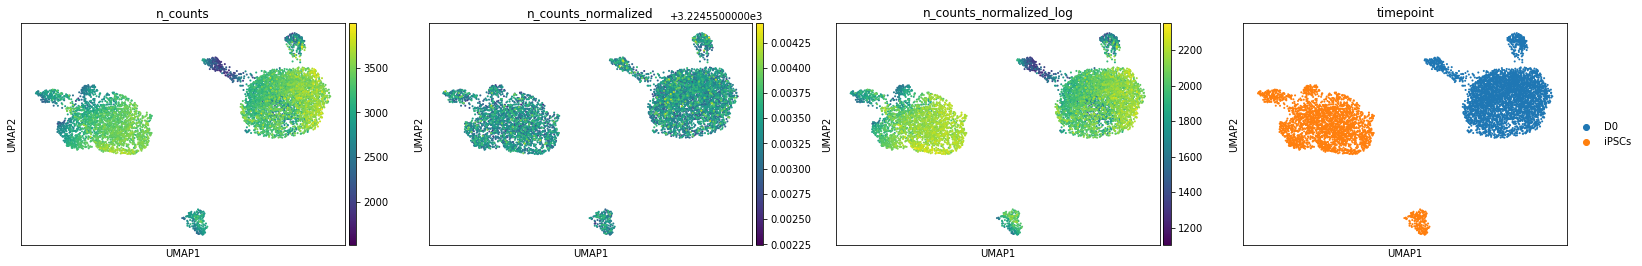

In [39]:
sc.tl.pca(all_data, svd_solver="arpack")
sc.pp.neighbors(all_data)
sc.tl.umap(all_data)
sc.pl.umap(all_data, color=["n_counts", "n_counts_normalized", "n_counts_normalized_log", "timepoint"])

### Enrichment Analysis

In [12]:
sc.tl.rank_genes_groups(all_data, groupby='timepoint', method='logreg', rankby_abs=True)

In [4]:
sc.tl.rank_genes_groups(all_data, groupby='timepoint', rankby_abs=True)

/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'timepoint' as categorical
/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges

In [7]:
all_data

AnnData object with n_obs × n_vars = 7158 × 14999
    obs: 'dataset', 'timepoint', 'sample id', 'n_counts_all'
    uns: 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [14]:
all_data.uns['rank_genes_groups']

{'params': {'groupby': 'timepoint',
  'reference': 'rest',
  'method': 'logreg',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Saa3',), ('Lcn2',), ('Mt2',), ..., ('Tpm1',), ('Myl9',),
            ('Acta2',)],
           dtype=[('D0', 'O')]),
 'scores': rec.array([( 0.04681149,), ( 0.04386578,), ( 0.04055651,), ...,
            (-0.03984759,), (-0.04051126,), (-0.04057991,)],
           dtype=[('D0', '<f4')])}

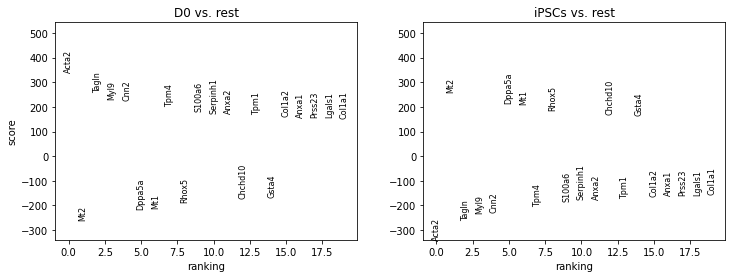

In [5]:
sc.pl.rank_genes_groups(all_data)

In [17]:
all_data.uns['rank_genes_groups']['scores']

rec.array([( 0.04681149,), ( 0.04386578,), ( 0.04055651,), ...,
           (-0.03984759,), (-0.04051126,), (-0.04057991,)],
          dtype=[('D0', '<f4')])

In [19]:
result

{'params': {'groupby': 'timepoint',
  'reference': 'rest',
  'method': 'logreg',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Saa3',), ('Lcn2',), ('Mt2',), ..., ('Tpm1',), ('Myl9',),
            ('Acta2',)],
           dtype=[('D0', 'O')]),
 'scores': rec.array([( 0.04681149,), ( 0.04386578,), ( 0.04055651,), ...,
            (-0.03984759,), (-0.04051126,), (-0.04057991,)],
           dtype=[('D0', '<f4')])}

In [ ]:
result = all_data.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
{group + '_' + key[:1]: result[key][group] for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})
# {group + '_' + key[:1]: result[key][group] for group in groups for key in ['names','pvals','pvals_adj']})
df.to_csv('ranked_genes.csv')

In [7]:
mrs = ["Tcfl5"
, "Elf2"
, "Sirt4"
, "Stat2"
, "Sh3d19"
, "Asb1"
, "Asb3"
, "Ighmbp2"
, "Ppard"
, "Foxo3"
,"Mllt1"
,"Daxx"
,"Invs"
,"Zfp27"
,"Zfp334"
,"Zfp398"
,"Mxi1"
,"Irf5"
,"Mynn"
,"Gmeb1"
,"Nfya"
,"Men1"
,"Maf"
,"Zfp51"
,"Ep300"
,"Cxxc1"
,"B930041F14Rik"
,"Tbp"
,"Atf7"
,"Asb6"
,"Bdp1"
,"Crem"
,"Tceal1"]

In [10]:
for mr in mrs:
    print(mr)
    row = df.loc[df['D0_n'] == mr]
    print(row)
    print("---------------------------------------------------------")

Tcfl5
       D0_n  D0_l          D0_p iPSCs_n  iPSCs_l       iPSCs_p
7454  Tcfl5   NaN  6.884880e-10   Tcfl5      NaN  6.884880e-10
---------------------------------------------------------
Elf2
       D0_n  D0_l      D0_p iPSCs_n  iPSCs_l   iPSCs_p
13161  Elf2   NaN  0.361397    Elf2      NaN  0.361397
---------------------------------------------------------
Sirt4
        D0_n  D0_l      D0_p iPSCs_n  iPSCs_l   iPSCs_p
12243  Sirt4   NaN  0.095427   Sirt4      NaN  0.095427
---------------------------------------------------------
Stat2
       D0_n  D0_l          D0_p iPSCs_n  iPSCs_l       iPSCs_p
6671  Stat2   NaN  2.500970e-13   Stat2      NaN  2.500970e-13
---------------------------------------------------------
Sh3d19
         D0_n  D0_l      D0_p iPSCs_n  iPSCs_l   iPSCs_p
13612  Sh3d19   NaN  0.605135  Sh3d19      NaN  0.605135
---------------------------------------------------------
Asb1
       D0_n  D0_l      D0_p iPSCs_n  iPSCs_l   iPSCs_p
13231  Asb1   NaN  0.395577    A

In [59]:
all_data.obs['timepoint']

AAACATACACTTTC-1_GSM2836267_D0._0             D0
AAACATACCTTGGA-1_GSM2836267_D0._0             D0
AAACATTGCTGTGA-1_GSM2836267_D0._0             D0
AAACATTGGTTCGA-1_GSM2836267_D0._0             D0
AAACATTGTCCTTA-1_GSM2836267_D0._0             D0
                                           ...  
TTTCGAACCGAATC-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTGGGATG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTTACTGG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTCTACTTATCGG-1_GSM2836284_iPSCs-2i._0    iPSCs
TTTGACTGCGCCTT-1_GSM2836284_iPSCs-2i._0    iPSCs
Name: timepoint, Length: 7158, dtype: object

In [6]:
adata = all_data
print(adata.X.shape)

# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)

(7158, 100)


In [53]:
groups = ['DO', 'iPSCs']

In [ ]:
# sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
# sc.pl.rank_genes_groups(adata)  

sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

In [21]:
highly_variable_genes = all_data_df.columns
import json
with open('genes_for_layer.json', 'r') as myfile:
    data=myfile.read()
obj = json.loads(data)
layer0genes = obj['0']
layer0genes

for layer, genes in obj.items():
    for gene in genes:
        if gene in highly_variable_genes:
            print(layer, gene)

43 Serpinb2
45 Gmcl1
46 Cxcl2
47 Rsad2
47 Crct1
48 Upk1b
48 Ptgds
48 Sprr1a
49 Coch
49 Ccl20
49 Cxcl10
49 Cp
49 Tmem176b
49 Serpine2
49 Fth1
49 Meg3
49 Acta2
49 Ifit3
49 Agl
49 Spp1
49 Itm2a
50 Mgp
50 Ccdc163
50 1500015O10Rik
50 mt-Nd1
50 Igfbp5
50 Crabp1
50 Col1a1
50 Ifit1
50 Ndufa4l2
50 Hp
50 Mylk
50 Il1rn
50 Ppbp
50 Actg2
50 Il1rl1
50 Ccl5
50 Msln
50 Tmem176a
50 Col2a1
50 Timp3
50 Wisp2
50 Adm
50 Fst
50 Ptn
50 Mgst1
50 Thbs1
50 Gpx3
50 S100a6
50 Ftl1
50 Mmp13
50 Tspan8
50 Postn
50 H19
50 Sprr2k
50 Cxcl5
50 Gpm6b
50 Mt1
50 Ptx3
50 Cxcl1
50 Actb
50 Malat1
50 Hsp90aa1
50 Isg15
50 Gas6
50 Fmod
51 Cdkn1c
51 Dcn
51 Lcn2
51 Col1a2
51 Gfod2
51 Cemip
51 mt-Cytb
51 Acta1
51 Krt18
51 Gsto1
51 Saa3
51 Mmp3
51 Sct
51 Rhox9
51 Apoe
51 Dppa5a
51 Cxcl14
51 Krt8
51 Ly6a
51 mt-Nd4
51 Dqx1
51 Igfbp2
51 Ccl7
51 Ccl2
51 Pfn1
51 Lgals1
51 Rhox6
51 Serpinh1
52 6330410L21Rik
52 Trap1a
52 Tmsb4x
52 Bhmt
52 Aqp3
52 Mt2


In [53]:
columns = all_data_df.columns

necessary_genes = ["Oct4", "Pou5f1", "Sox2", "Klf4", "Myc"]

for gene in columns:
    if gene in necessary_genes:
        print(gene)

Sox2
Klf4
Myc
Pou5f1


In [71]:
SAVE2CSV = True
if SAVE2CSV:
    all_data_df.to_csv("./data-for-the-expert/1k_D0_ipsc_norm.csv", index=False)
    np.save("./data-for-the-expert/column_names_1k_D0_ipsc_norm.csv", all_data_df.columns)

In [38]:
labels = np.array([1 if 'iPSCs-2i._0' in sample else 0 for sample in all_data_df.index])
np.save("labels_15k_genes.npy", labels)
print("            NUM SAMPLES   ")
print("------------------------------------")
print("class D0 | class D18 | tot samples ")
print("------------------------------------")
print(f"  #{sum(labels == 1)}   |    #{len(labels)-sum(labels == 1)}   |    #{len(labels)}")

            NUM SAMPLES   
------------------------------------
class D0 | class D18 | tot samples 
------------------------------------
  #2917   |    #4241   |    #7158


In [42]:
np.save("columns_names_genes_in_order.npy", all_data_df.columns)

In [53]:
columns = all_data_df.columns

In [70]:
all_data.obsm['X_pca'].shape

(4241, 50)

In [13]:
 dt = scipy.io.mmread('D0/GSM2836267_D0.matrix.mtx.gz').transpose().toarray()

In [15]:
dt.shape

(4241, 27998)

In [11]:
d0_data_scanpy = sc.read_10x_mtx('D0/', prefix='GSM2836267_D0.')
d0_data_scanpy_df = d0_data_scanpy.to_df()
d0_data_scanpy_df

In [61]:
ipsc_data = sc.read_10x_mtx('raw/', prefix='GSM2836284_iPSCs-2i.')
ipsc_data_to_df = ipsc_data.to_df()
ipsc_data_to_df

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACTGAGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTGAGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
AAACCGTGCATCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAGCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACGGCTACTCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCGAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGGGATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTACTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTTCTACTTATCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [62]:
ipsc_data_serum = sc.read_10x_mtx('raw/', prefix='GSM2836288_iPSCs-serum.')
ipsc_data_to_df_serum = ipsc_data.to_df()
ipsc_data_to_df_serum

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACATACTGAGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTGAGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
AAACCGTGCATCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAGCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACGGCTACTCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACCGAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTGGGATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTTACTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTTCTACTTATCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### t-SNE of all data D0 and D18.

/home/ionelia/pycharm-projects/venvs/grn-control/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


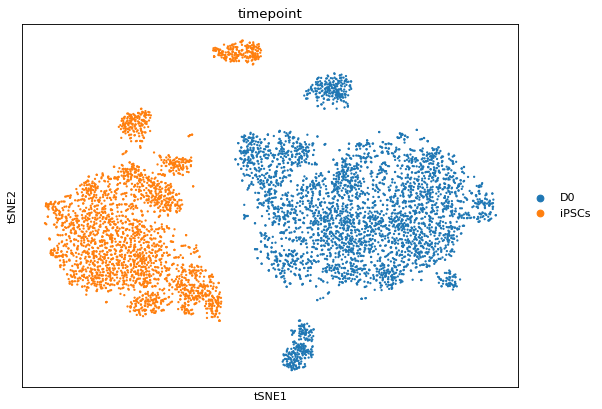

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80)
dataset = all_data
sc.tl.tsne(dataset, use_rep='X_pca_harmony')
sc.pl.tsne(dataset, color='timepoint', ax=ax, show = False)
plt.show()

In [21]:
all_data.obs['timepoint']=='D0'

,dataset,timepoint,sample id,n_counts_all
AAACATACACTTTC-1_GSM2836267_D0._0,shiebinger,D0,0,7066.0
AAACATACCTTGGA-1_GSM2836267_D0._0,shiebinger,D0,0,4166.0
AAACATTGCTGTGA-1_GSM2836267_D0._0,shiebinger,D0,0,3970.0
AAACATTGGTTCGA-1_GSM2836267_D0._0,shiebinger,D0,0,2701.0
AAACATTGTCCTTA-1_GSM2836267_D0._0,shiebinger,D0,0,9687.0
...,...,...,...,...
TTTCGAACCGAATC-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,11480.0
TTTCTACTGGGATG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,6179.0
TTTCTACTTACTGG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,16405.0
TTTCTACTTATCGG-1_GSM2836284_iPSCs-2i._0,shiebinger,iPSCs,0,14032.0


### Calculate basal production rates for mater regulators

In [9]:
with open("genes_for_layer.json", "r") as read_file:
    master_regulators = json.load(read_file)['0']
master_regulators    

['Tcfl5',
 'Elf2',
 'Sirt4',
 'Stat2',
 'Sh3d19',
 'Asb1',
 'Asb3',
 'Ighmbp2',
 'Ppard',
 'Foxo3',
 'Mllt1',
 'Daxx',
 'Invs',
 'Zfp27',
 'Zfp334',
 'Zfp398',
 'Mxi1',
 'Irf5',
 'Mynn',
 'Gmeb1',
 'Nfya',
 'Men1',
 'Maf',
 'Zfp51',
 'Ep300',
 'Cxxc1',
 'B930041F14Rik',
 'Tbp',
 'Atf7',
 'Asb6',
 'Bdp1',
 'Crem',
 'Tceal1']

In [63]:
# load gene name converted to integer
with open("json_gene_name_as_string_and_int_id.json", "r") as read_file:
    genes_names_to_int = json.load(read_file)['name_to_int']

In [14]:
all_genes = d0_data_scanpy.columns
debug_how_many_ms_in_dataset = 0
for master_regulator in master_regulators:
    if master_regulator in all_genes:
        debug_how_many_ms_in_dataset += 1
print(f"tot MRs {len(master_regulators)} | matching: {debug_how_many_ms_in_dataset}")

tot MRs 33 | matching: 33


### MRs mean expressions of individual clasters without normalization.

In [66]:
for mr in master_regulators:
    d0_mr_expressions = d0_data_scanpy[mr]
    ipsc_mr_expressions = ipsc_data_to_df[mr]
    print(f"{genes_names_to_int[mr]}, {mr_expressions.mean()*0.8}, {ipsc_mr_expressions.mean()*0.8}")

2036, 0.0522518277168274, 0.01426122784614563
2745, 0.0522518277168274, 0.2114501237869263
4875, 0.0522518277168274, 0.059513199329376223
7867, 0.0522518277168274, 0.03236201703548432
2861, 0.0522518277168274, 0.1234144687652588
407, 0.0522518277168274, 0.05649639964103699
10165, 0.0522518277168274, 0.07103188037872314
14473, 0.0522518277168274, 0.07267740964889527
13608, 0.0522518277168274, 0.09818306565284729
7357, 0.0522518277168274, 0.052656841278076176
13965, 0.0522518277168274, 0.03126499950885773
13696, 0.0522518277168274, 0.289612627029419
3546, 0.0522518277168274, 0.016455262899398804
6345, 0.0522518277168274, 0.019197805225849154
1935, 0.0522518277168274, 0.008501885831356049
5449, 0.0522518277168274, 0.06582105159759521
14929, 0.0522518277168274, 0.11162153482437134
5353, 0.0522518277168274, 0.01508399099111557
2674, 0.0522518277168274, 0.13822420835494995
3973, 0.0522518277168274, 0.16592389345169067
13905, 0.0522518277168274, 0.12396297454833985
14593, 0.0522518277168274, 

### MRs means expressions of both clusters after norm.

In [58]:
d0_df = all_data[all_data.obs['timepoint']=='D0'].to_df()
for mr in master_regulators:
    mr_expressions = d0_df[mr]
    print(mr_expressions.mean(), mr_expressions.mean()*0.8)

0.054204937 0.04336394965648652
0.009379327 0.007503461837768555
0.016322846 0.013058276474475862
0.0650919 0.052073520421981816
-0.0056142556 -0.004491404443979263
0.008728312 0.006982649862766266
0.064061984 0.051249587535858156
-0.028932 -0.0231455996632576
0.03307372 0.026458975672721863
-0.039166644 -0.031333315372467044
0.08435858 0.0674868643283844
0.007998999 0.006399199366569519
0.08255089 0.06604071259498596
0.020866226 0.016692981123924255
0.07862863 0.06290290355682374
-0.031003362 -0.024802689254283906
-0.046178233 -0.03694258630275726
0.03859585 0.030876681208610535
-0.042967804 -0.03437424302101135
-0.0075598215 -0.00604785718023777
0.0046516745 0.003721339628100395
0.029744457 0.023795565962791445
0.06841695 0.054733562469482425
0.015412791 0.012330232560634613
-0.010062252 -0.008049801737070084
0.059993077 0.047994461655616764
-0.043772813 -0.03501825034618378
0.0039660335 0.0031728267669677737
0.050602034 0.040481626987457275
0.031889305 0.025511443614959717
-0.008739

In [60]:
d0_df = all_data[all_data.obs['timepoint']=='iPSCs'].to_df()
for mr in master_regulators:
    mr_expressions = d0_df[mr]
    print(mr_expressions.mean(), mr_expressions.mean()*0.8)

-0.07880806 -0.06304644942283631
-0.013636448 -0.010909158736467361
-0.02373166 -0.01898532807826996
-0.094636515 -0.07570921182632447
0.008162554 0.006530043482780457
-0.012690112 -0.010152089595794679
-0.093139105 -0.07451128363609315
0.042063955 0.033651164174079894
-0.048085608 -0.03846848607063294
0.056944042 0.0455552339553833
-0.12264818 -0.09811854362487793
-0.011629694 -0.009303755313158036
-0.12001997 -0.09601597785949707
-0.030337218 -0.024269774556159973
-0.11431747 -0.09145397543907166
0.045075536 0.036060428619384764
0.067138165 0.05371053218841553
-0.05611418 -0.044891342520713806
0.062470477 0.049976381659507754
0.010991085 0.008792868256568909
-0.006763022 -0.005410417541861535
-0.0432452 -0.03459616005420685
-0.09947084 -0.07957667112350464
-0.022408444 -0.017926755547523498
0.014629399 0.011703519523143769
-0.08722344 -0.06977875232696533
0.06364092 0.05091273784637451
-0.0057662046 -0.004612963646650314
-0.07356981 -0.05885584950447083
-0.04636357 -0.037090855836868